In [1]:
import numpy as np
from scipy.stats import norm
import scipy.linalg as LA
import scipy.optimize as opt
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve
import pandas as pd

In [2]:
#define the input
np.random.seed(42)

# define the deterministic function (two function with two different omega)

def f1(x): return np.sin(x) # omega = 1

def f2(x): return np.cos(2 * x) # omega = 2

# the true mixing matrix
A = np.array([[1.0, -0.5],
              [0.8, 0.7]])

# random select 60 input points from range 0-10
X_train = np.sort(np.random.choice(np.linspace(0, 2*np.pi, 200), size=30, replace=False)).reshape(-1, 1) #sampling data nad reshape to columns

# select 40 points in [0,15] not overlap with training point
X_pool = np.linspace(0.01, 4*np.pi, 400)
X_test_candidates = np.setdiff1d(np.round(X_pool, 4), np.round(X_train.flatten(), 4))
X_test = np.sort(np.random.choice(X_test_candidates, size=200, replace=False)).reshape(-1, 1)

In [3]:
# checking whether they have overlaping between the test and train
a = np.linspace(0, 2*np.pi, 200)

In [4]:
b = np.linspace(0.01, 4*np.pi, 400)

In [5]:
c = set(a) & set(b)
c

set()

In [6]:
# get the latent function val
f1_train = f1(X_train).flatten()
f2_train = f2(X_train).flatten()
f1_test = f1(X_test).flatten()
f2_test = f2(X_test).flatten()

In [7]:
f1_train

array([ 0.45609916,  0.4839656 ,  0.8117917 ,  0.98877473,  0.98059231,
        0.94808684,  0.88630108,  0.87123964,  0.85530974,  0.83852724,
        0.82090888,  0.62788797,  0.52485216,  0.47009096,  0.20379202,
        0.14160452, -0.47009096, -0.69868515, -0.72092198, -0.78323563,
       -0.85530974, -0.99922127, -0.99623282, -0.96207936, -0.87887988,
       -0.79295273, -0.70989202, -0.64009622, -0.51134962, -0.39903056])

In [8]:
f2_train

array([ 0.58394711,  0.53155459, -0.31801154, -0.95535095, -0.92312256,
       -0.79773733, -0.57105921, -0.51811703, -0.46310949, -0.40625585,
       -0.34778276,  0.21151339,  0.44906041,  0.55802898,  0.91693763,
        0.95989632,  0.55802898,  0.02367813, -0.039457  , -0.22691611,
       -0.46310949, -0.99688629, -0.98495967, -0.8511934 , -0.54485968,
       -0.25754807, -0.00789337,  0.18055365,  0.47704314,  0.68154923])

In [9]:
## visualize the two function

A_true = np.array([[1.0, -0.5],
                   [0.8, 0.7]])

# noise
sigma1, sigma2 = 0.1, 0.1 # training data point noise

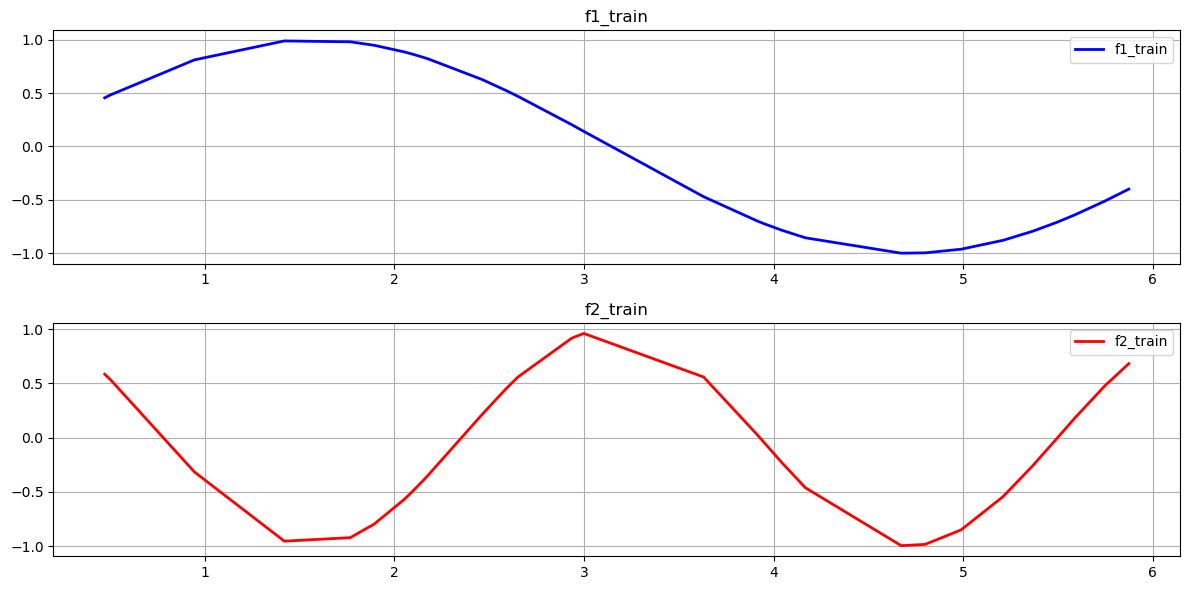

In [10]:
plt.figure(figsize=(12, 6))

plt.subplot(2,1,1)
plt.title("f1_train")
plt.plot(X_train, f1_train, color='blue', label='f1_train', linewidth=2)
plt.grid(True)
plt.legend()

plt.subplot(2,1,2)
plt.title("f2_train")
plt.plot(X_train, f2_train, color='red', label='f2_train', linewidth=2)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# generate the output / ground truth

#train output + noise
y1_train = A_true[0, 0] * f1_train + A_true[0, 1] * f2_train + np.random.normal(0, sigma1, size=f1_train.shape)
y2_train = A_true[1, 0] * f1_train + A_true[1, 1] * f2_train + np.random.normal(0, sigma2, size=f2_train.shape)

#test output
y1_test = A_true[0, 0] * f1_test + A_true[0, 1] * f2_test
y2_test = A_true[1, 0] * f1_test + A_true[1, 1] * f2_test

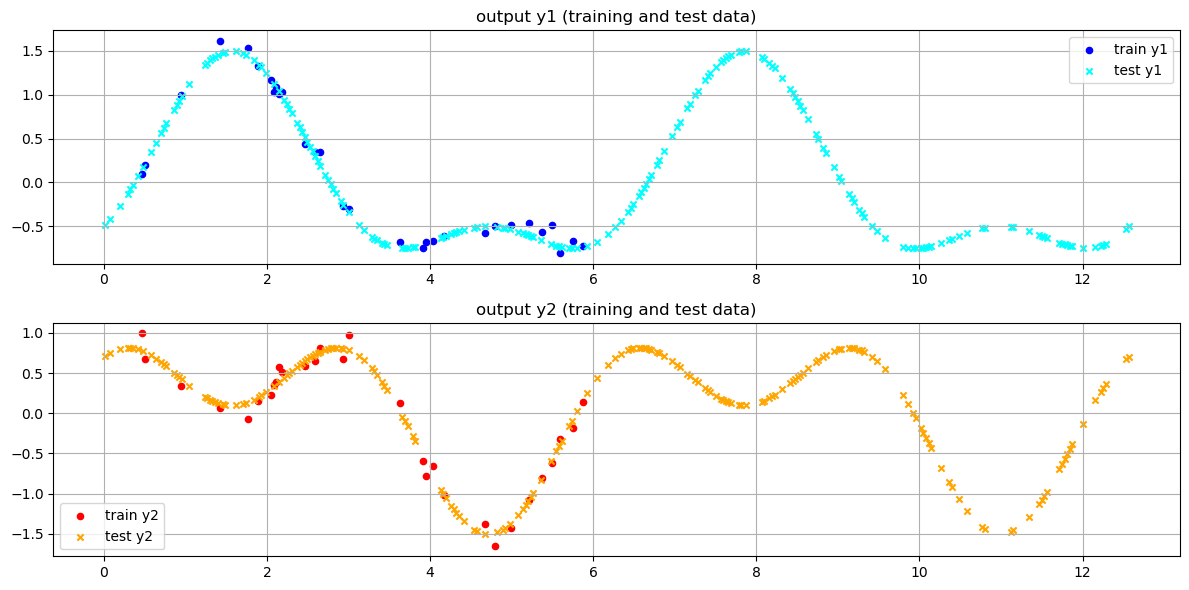

In [12]:
# plot two outputs

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.title("output y1 (training and test data)")
plt.scatter(X_train, y1_train, color='blue', label='train y1', s=20)
plt.scatter(X_test, y1_test, color='cyan', label='test y1', s=20, marker='x')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.title("output y2 (training and test data)")
plt.scatter(X_train, y2_train, color='red', label='train y2', s=20)
plt.scatter(X_test, y2_test, color='orange', label='test y2', s=20, marker='x')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
train_data = {
    'X': X_train,
    'y1': y1_train,
    'y2': y2_train,
    'f1': f1_train,
    'f2': f2_train
}

test_data = {
    'X': X_test,
    'y1': y1_test,
    'y2': y2_test,
    'f1': f1_test,
    'f2': f2_test
}

A_true, train_data, test_data

Y_train = np.vstack([y1_train.reshape(-1, 1), y2_train.reshape(-1, 1)])
Y_train.shape

(60, 1)

In [14]:
# define the kernel for the SOGP
def periodic_kernel(X1, X2, lengthscale, variance, period):
  X_1 = np.atleast_2d(X1).reshape(-1, 1)
  X_2 = np.atleast_2d(X2).reshape(-1, 1)
  dists = np.abs(X1 - X2.T)
  sin_term = np.sin(np.pi * dists / period)
  return variance**2 * np.exp(-2 * (sin_term**2) / lengthscale**2)

In [15]:
X_train.shape

(30, 1)

In [16]:
#visualize the training data
correlation_matrix = periodic_kernel(X_train, X_train, lengthscale=1.0, variance=1.0, period=1.0)
correlation_matrix

array([[1.        , 0.98057744, 0.13720471, 0.94695991, 0.27911607,
        0.15277645, 0.15255304, 0.17042558, 0.19622634, 0.23157242,
        0.27829269, 0.99767947, 0.77744842, 0.5676603 , 0.13907468,
        0.13713571, 0.63740834, 0.14466952, 0.13727501, 0.14800267,
        0.26083898, 0.50313771, 0.23284039, 0.13594149, 0.33708597,
        0.80738784, 0.99196224, 0.77903333, 0.31888796, 0.16435097],
       [0.98057744, 1.        , 0.1445105 , 0.87178039, 0.3391581 ,
        0.17076126, 0.14135233, 0.15255304, 0.17042558, 0.19622634,
        0.23157242, 0.96529859, 0.87313325, 0.67222568, 0.14838205,
        0.13542119, 0.7434289 , 0.15814758, 0.14466952, 0.13887904,
        0.21823658, 0.60298843, 0.2799426 , 0.13606574, 0.27747248,
        0.7038433 , 0.99746578, 0.87448107, 0.38866007, 0.18764138],
       [0.13720471, 0.1445105 , 1.        , 0.13720471, 0.56608845,
        0.94695991, 0.81045122, 0.7071364 , 0.60137711, 0.50166968,
        0.41343231, 0.13598161, 0.19622634, 0.

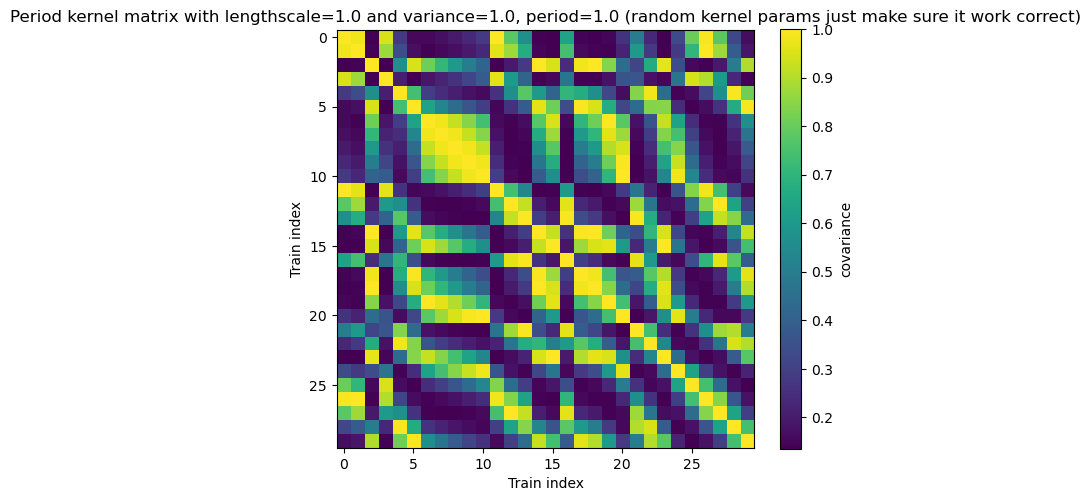

In [17]:
#plot it
plt.figure(figsize=(6,5))
plt.imshow(correlation_matrix, cmap='viridis')
plt.colorbar(label='covariance')
plt.title(f"Period kernel matrix with lengthscale=1.0 and variance=1.0, period=1.0 (random kernel params just make sure it work correct)")
plt.xlabel("Train index")
plt.ylabel("Train index")
plt.tight_layout()
plt.show()

In [18]:
# using the same periodic kernel for both function learning individualy
def nll_periodic(params, X_train, Y_train):
    #get hyper params value
    sigma_f, length_scale_l, period_p, noise = params
    
    # get the covariance matrix
    K = periodic_kernel(X_train, X_train, lengthscale=length_scale_l, variance=sigma_f, period=period_p)
    
    # add noise and a small jiter for stablize the result (make the covariance matrix does not become singular)
    K += (noise**2 + 1e-6) * np.eye(len(X_train))
    
    # cholesky decomp for efficient compute
    L = LA.cholesky(K, lower=True)
    
    # solve to get alpha = K^-1 * y
    alpha = LA.cho_solve((L, True), Y_train)
    
    # get negative log likelihood
    nll = 0.5 * Y_train.T @ alpha + np.sum(np.log(np.diag(L))) + 0.5 * len(X_train) * np.log(2*np.pi)
    return nll.item()

In [19]:
# prediction
def sogp_periodic_prediction(X_train, X_test, Y_train, optimized_params):
    sigma_f, length_scale_l, period_p, noise = optimized_params
    # getting the inverse cov train with cholesky
    K = periodic_kernel(X_train, X_train, lengthscale=length_scale_l, variance=sigma_f, period=period_p)
    
    # add noise and a small jiter for stablize the result (make the covariance matrix does not become singular)
    K += (noise**2 + 1e-6) * np.eye(len(X_train))
    
    # cholesky decomp for efficient compute
    L = LA.cholesky(K, lower=True)
    
    # solve to get alpha = K^-1 * y
    alpha = LA.cho_solve((L, True), Y_train)

    K_s = periodic_kernel(X_train, X_test, lengthscale=length_scale_l, variance=sigma_f, period=period_p)
    #getting the mean: y_test = K_s*K-1*y_train
    mean = K_s.T @ alpha

    K_ss = periodic_kernel(X_test, X_test, lengthscale=length_scale_l, variance=sigma_f, period=period_p)
    v = LA.solve_triangular(L, K_s, lower=True) ## getting the v = L \ K_s
    var = np.diag(K_ss) - np.sum(v**2, axis=0) # getting predict variance
    return mean.ravel(), np.maximum(var, 0)

In [78]:
y1_train

array([ 0.09228118,  0.19684359,  1.00188823,  1.61398583,  1.52791955,
        1.33096165,  1.16992906,  1.03004522,  1.08501316,  1.0127893 ,
        1.02707211,  0.43940819,  0.35225661,  0.34435036, -0.26555281,
       -0.29817247, -0.68009105, -0.75064626, -0.67878423, -0.66851834,
       -0.61398738, -0.5780791 , -0.50130197, -0.48668283, -0.46133568,
       -0.56825161, -0.49062709, -0.8071078 , -0.66263912, -0.72147097])

In [20]:
#test the nll function
# nll_periodic_test_val = nll_periodic([1.0, 1.0, 1.0, 0.01], X_train, y1_train)
# nll_periodic_test_val

In [21]:
# test the sogp_periodic func
# sogp_periodic_prediction_test_val = sogp_periodic_prediction(X_train, X_test, y1_train, [1.0, 1.0, 1.0, 0.01])
# sogp_periodic_prediction_test_val

In [110]:
# run & optimize for each output independently

def run_opt_for_each_output_indep(X_train, Y_train, X_test, Y_test, output_order):
    init_value = [1.0, 1.0, 2*np.pi, 0.1]
    
    # set the bounds for params
    bounds = [(0.1, 15.0), (0.1, 10.0), (1.0, 10.0), (1e-3, None)] #order: sigma_f, length_scale, period, noise
    
    res = opt.minimize(nll_periodic, init_value, args=(X_train, Y_train), method='L-BFGS-B', bounds=bounds)
    
    params_opt = res.x

    print(f"Optimized params for output {output_order}: \n {params_opt}")

    lml = -res.fun
    print(f"Log Marginal Likelihood of the {output_order:} {lml:.4f}")

    mean, var = sogp_periodic_prediction(X_train, X_test, Y_train, params_opt)
    mse = np.mean((mean - Y_test.ravel())**2)
    print(f"Test Mean Square Error for output {output_order}: {mse:.4f}")

    return mean, var

In [112]:
# test the optimize and predict function
print("-------------Output 1--------------")
mu_0, var_0 = run_opt_for_each_output_indep(X_train, y1_train, X_test, y1_test, output_order="Output 1")

print("-------------Output 2--------------")
mu_1, var_1 = run_opt_for_each_output_indep(X_train, y2_train, X_test, y2_test, output_order="Output 2")

-------------Output 1--------------
Optimized params for output Output 1: 
 [1.31716174 1.47021395 6.32332998 0.0683978 ]
Log Marginal Likelihood of the Output 1 17.9618
Test Mean Square Error for output Output 1: 0.0049
-------------Output 2--------------
Optimized params for output Output 2: 
 [1.29629095 1.2520754  6.50289751 0.11719695]
Log Marginal Likelihood of the Output 2 4.3699
Test Mean Square Error for output Output 2: 0.0323


In [114]:
mu_0

array([-0.553758  , -0.49187468, -0.33806685, -0.19831273, -0.14749015,
       -0.09476473,  0.01567033,  0.13196431,  0.31472413,  0.4395445 ,
        0.56504113,  0.62762549,  0.68975352,  0.87110992,  0.92914095,
        0.98587011,  1.04091522,  1.19394304,  1.43188871,  1.46121988,
        1.48732569,  1.51007121,  1.52954744,  1.54563652,  1.56753781,
        1.57337328,  1.56299989,  1.52120538,  1.50126386,  1.42454284,
        1.36051877,  1.32515839,  1.24797445,  1.11886528,  1.0255613 ,
        0.92762445,  0.87748988,  0.82649784,  0.7749431 ,  0.67084227,
        0.61838708,  0.56588209,  0.51361267,  0.4613607 ,  0.40940379,
        0.35801158,  0.30695888,  0.25650805,  0.20690945,  0.10983142,
        0.06267571,  0.0166891 , -0.02835066, -0.07222919, -0.15613159,
       -0.19617986, -0.27197951, -0.40597672, -0.46364972, -0.53831246,
       -0.56004294, -0.58019035, -0.61573788, -0.63123127, -0.64521485,
       -0.69915827, -0.70352139, -0.70669536, -0.70962585, -0.70

In [116]:
std_0 = np.sqrt(var_0)
std_1 = np.sqrt(var_1)

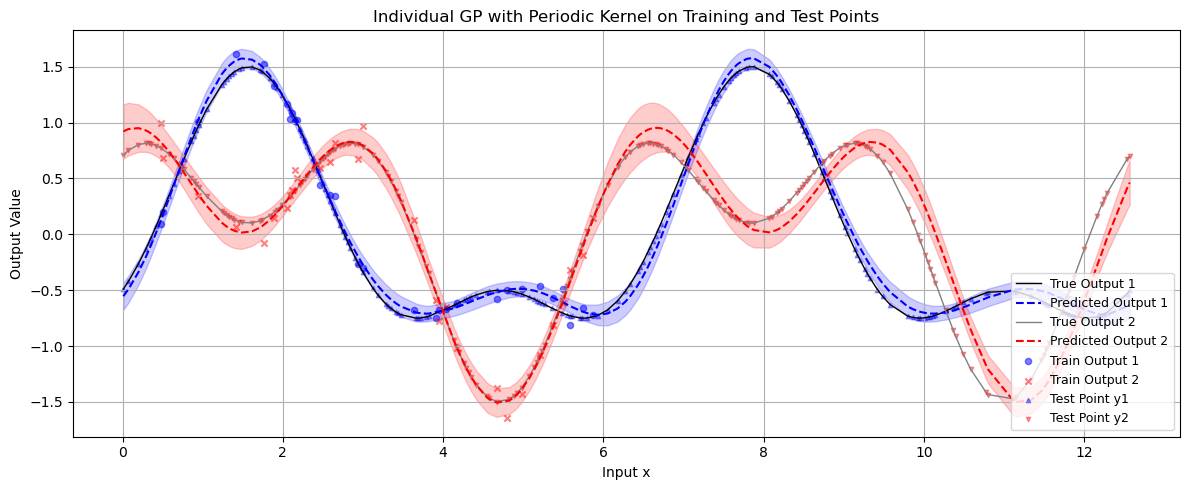

In [118]:
# plot predictions and uncertainties with training and test points highlighted
fig, ax = plt.subplots(figsize=(12, 5))

X_train_flat = X_train.flatten()
X_test_flat = X_test.flatten()

# plot true and predicted for output 1
ax.plot(X_test, y1_test, label="True Output 1", color="black", linewidth=1)
ax.plot(X_test, mu_0, label="Predicted Output 1", linestyle="--", color="blue")
ax.fill_between(X_test_flat,
                mu_0 - 2 * std_0,
                mu_0 + 2 * std_0,
                color="blue", alpha=0.2)

# plot true and predicted for output 2
ax.plot(X_test, y2_test, label="True Output 2", color="gray", linewidth=1)
ax.plot(X_test, mu_1, label="Predicted Output 2", linestyle="--", color="red")
ax.fill_between(X_test_flat,
                mu_1 - 2 * std_1,
                mu_1 + 2 * std_1,
                color="red", alpha=0.2)

# training points
ax.scatter(X_train, y1_train, color="blue", s=20, label="Train Output 1", alpha=0.5, marker='o')
ax.scatter(X_train, y2_train, color="red", s=20, label="Train Output 2", alpha=0.5, marker='x')

# test points (without noise)
ax.scatter(X_test, y1_test, color="blue", s=10, label="Test Point y1", alpha=0.4, marker='^')
ax.scatter(X_test, y2_test, color="red", s=10, label="Test Point y2", alpha=0.4, marker='v')

# settings
ax.set_title("Individual GP with Periodic Kernel on Training and Test Points")
ax.set_xlabel("Input x")
ax.set_ylabel("Output Value")
ax.legend(loc="lower right", fontsize=9)
ax.grid(True)

plt.tight_layout()
plt.show()